In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors, Descriptors, DataStructs
from PIL import Image, ImageDraw, ImageFont
import os
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

def oecd_pfas(smiles):
    # follow revised OCED definition
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError('Error on parse SMILES string')

    mol = Chem.AddHs(mol)
    # for atom in mol.GetAtoms():
    #     print(atom.GetSymbol())
    # Iterate through atoms and check if there are CF3 or CF2 groups
    for atom in mol.GetAtoms():
        # Check for perfluorinated methyl group (-CF3)
        if atom.GetSymbol() == 'C' and atom.GetDegree() >= 2:
            neighbors = [nbr.GetSymbol() for nbr in atom.GetNeighbors()]
            if neighbors.count('F') >= 2 and not any([nbr in ['H', 'Br', 'I', 'Cl'] for nbr in neighbors]):
                # print(neighbors)
                return True  # Perfluorinated methyl group found

    return False

def draw_molecule_tile(
    mol,
    top_text="",
    bottom_lines=None,
    mol_size=(200, 200),
    top_margin=30,
    bottom_margin=50,
    groudtruth=False
):
    """
    Renders a single 'tile' image containing:
      - A top_text (centered at the top)
      - The RDKit molecule in the middle
      - One or more lines of text at the bottom

    If mol is None, this creates an empty tile with no molecule.

    :param mol: RDKit Mol object or None (for an empty tile)
    :param top_text: str, text to display at the top
    :param bottom_lines: list of strings to show at the bottom
    :param mol_size: (width, height) of the area reserved for the molecule
    :param top_margin: height of the top area for the title
    :param bottom_margin: height of the bottom area for lines
    :return: A PIL Image
    """
    if bottom_lines is None:
        bottom_lines = []

    # Create the tile background
    total_width = mol_size[0]
    total_height = top_margin + mol_size[1] + bottom_margin
    tile_img = Image.new('RGB', (total_width, total_height), 'white')

    draw = ImageDraw.Draw(tile_img)
    # font = ImageFont.load_default()
    if len(bottom_lines) < 5:
        font_top = ImageFont.truetype('/Library/Fonts/Arial Unicode.ttf', 35)
        font_down = ImageFont.truetype('/Library/Fonts/Arial Unicode.ttf', 35)
        
    else:
        font_top = ImageFont.truetype('/Library/Fonts/Arial Unicode.ttf', 30)
        font_down = ImageFont.truetype('/Library/Fonts/Arial Unicode.ttf', 30)

    # 1) Draw top text (centered)
    if top_text:
        top_bbox = draw.textbbox((0, 0), top_text, font=font_top)
        text_width = top_bbox[2] - top_bbox[0]
        text_height = top_bbox[3] - top_bbox[1]
        x_top = (total_width - text_width) / 2
        y_top = (top_margin - text_height) / 2
        draw.text((x_top, y_top), top_text, fill=(0, 0, 0), font=font_top, align='center')

    # 2) Draw molecule if present
    if mol is not None:
        # if groudtruth:
        #     mol_size = tuple(ms * 1.2 for ms in mol_size)
        mol_img = Draw.MolToImage(mol, size=mol_size)
        tile_img.paste(mol_img, (0, top_margin))

    # 3) Draw bottom text lines
    line_y = top_margin + mol_size[1]
    for line in bottom_lines:
        bbox = draw.textbbox((0, 0), line, font=font_down)
        line_width = bbox[2] - bbox[0]
        line_height = bbox[3] - bbox[1]

        x_line = (total_width - line_width) / 2
        draw.text((x_line, line_y), line, fill=(0, 0, 0), font=font_down, align='center')

        line_y += line_height + 2

    return tile_img


def make_5x5_grid_with_correct_center(
    correct_mol, correct_name, correct_formula, correct_mass, correct_smi, confidence_level,
    cand_mols, cand_formulas, cand_masses, cand_sims, cand_losses, cand_mw_diffes, cand_is_pfas,
    mol_size=(200, 200),
    top_margin=30,
    bottom_margin=50,
    horizontal_gap=20,   # extra space (pixels) between columns
    vertical_gap=20,     # extra space (pixels) between rows
    save_path=None,
    output_format="png"
):
    """
    Creates a 5x5 = 25-slot grid:
      - First row (indices 0..4) contains ONLY one molecule in slot 2 (the correct molecule).
        Slots 0,1,3,4 in that row are empty.
      - The remaining 20 slots (indices 5..24) are filled with 20 candidate molecules.

    Adds adjustable horizontal and vertical gaps to reduce a 'crowded' look.

    :param correct_mol: RDKit Mol (the correct molecule)
    :param correct_name: str, top text for correct molecule
    :param correct_formula: str, bottom text line for correct molecule
    :param correct_mass: float, bottom text line for correct molecule
    :param cand_mols: list[RDKit Mol] of length 20
    :param cand_formulas: list[str] of length 20
    :param cand_masses: list[float] of length 20
    :param cand_sims: list[float] of length 20
    :param mol_size: (width, height) for each molecule tile
    :param top_margin: vertical space at the top (pixels)
    :param bottom_margin: vertical space at the bottom (pixels)
    :param horizontal_gap: extra space (pixels) between columns
    :param vertical_gap: extra space (pixels) between rows
    :param save_path: If provided, save the image (PNG or rasterized SVG)
    :param output_format: "png" or "svg"
    :return: PIL Image
    """

    import os

    if not (len(cand_mols) == len(cand_formulas) == len(cand_masses) == len(cand_sims) == 20):
        raise ValueError("Need exactly 20 candidates with matching metadata.")

    # Prepare the 25 tiles (5x5 grid)
    total_slots = 25
    tiles = [None] * total_slots

    # Place correct molecule in slot=2 (row 0 col 2)
    tiles[2] = ("correct", correct_mol)

    # Fill the rest (slots 5..24 => 20 slots) with candidate molecules
    cand_index = 0
    for slot_i in range(total_slots):
        if slot_i in [0, 1, 2, 3, 4]:
            if slot_i != 2:
                tiles[slot_i] = ("empty", None)
        else:
            tiles[slot_i] = ("candidate", cand_mols[cand_index])
            cand_index += 1

    # Build each tile
    tile_imgs = []
    topk_counter = 1

    for role, mol in tiles:
        if role == "correct":
            # top text
            top_text = correct_name
            # bottom lines
            bottom_text = [
                f"\n{correct_formula}",
                f"\nmw: {correct_mass:.4f} Da",
                f'\nis PFAS: {correct_smi}',
                f'\nConfidence Level: {confidence_level:.2f}%']
            groudtruth = True
        elif role == "candidate":
            top_text = f"Top-{topk_counter}"
            sim = cand_sims[topk_counter - 1]
            form = cand_formulas[topk_counter - 1]
            mass = cand_masses[topk_counter - 1]
            loss = cand_losses[topk_counter - 1]
            mw_diff = cand_mw_diffes[topk_counter - 1]
            is_pfas = cand_is_pfas[topk_counter - 1]
            bottom_text = [
                f"{form}",
                f"\ndistance: {loss:.4f}",
                f"\nfps: {sim:.2f}",
                f"\nmw: {mass:.4f} Da",
                f"\nmw_diff: {mw_diff:.4f} Da",
                f"\nis PFAS: {is_pfas}"
            ]
            topk_counter += 1
            groudtruth = False
        else:
            top_text = ""
            bottom_text = []
            groudtruth = False
        tile = draw_molecule_tile(
            mol=mol,
            top_text=top_text,
            bottom_lines=bottom_text,
            mol_size=mol_size,
            top_margin=top_margin,
            bottom_margin=bottom_margin,
            groudtruth=groudtruth
        )
        tile_imgs.append(tile)

    # We have 5 rows, each row has 5 tiles
    num_rows, num_cols = 5, 5
    row_imgs = []
    idx = 0
    for _ in range(num_rows):
        row_slice = tile_imgs[idx : idx + num_cols]
        idx += num_cols

        # row width = sum of tile widths + horizontal_gap*(num_cols-1)
        row_w = sum(im.width for im in row_slice) + horizontal_gap * (num_cols - 1)
        row_h = max(im.height for im in row_slice)
        row_img = Image.new('RGB', (row_w, row_h), 'white')

        x_offset = 0
        for im in row_slice:
            row_img.paste(im, (x_offset, 0))
            x_offset += im.width + horizontal_gap

        row_imgs.append(row_img)

    # final image height = sum of row heights + vertical_gap*(num_rows-1)
    final_w = max(r.width for r in row_imgs)
    final_h = sum(r.height for r in row_imgs) + vertical_gap * (num_rows - 1)
    final_img = Image.new('RGB', (final_w, final_h), 'white')

    y_offset = 0
    for i, r in enumerate(row_imgs):
        final_img.paste(r, (0, y_offset))
        y_offset += r.height + vertical_gap

    # Optionally save image
    if save_path:
        # Normalize output_format
        fmt = output_format.lower()
        if fmt not in ["png", "svg"]:
            print(f"Unsupported output format '{fmt}'. Falling back to PNG.")
            fmt = "png"

        if fmt == "svg":
            # We'll embed a raster PNG in an SVG
            temp_png = os.path.splitext(save_path)[0] + "_temp.png"
            final_img.save(temp_png, format="PNG")

            import base64
            import io
            with open(temp_png, "rb") as png_f:
                b64_data = base64.b64encode(png_f.read()).decode("utf-8")

            svg_data = f"""<svg width="{final_w}" height="{final_h}" version="1.1"
xmlns="http://www.w3.org/2000/svg">
<image href="data:image/png;base64,{b64_data}" x="0" y="0" width="{final_w}" height="{final_h}" />
</svg>"""

            with open(save_path, "w") as svg_f:
                svg_f.write(svg_data)

            os.remove(temp_png)
        else:
            final_img.save(save_path, format="PNG")

    return final_img


# -----------------------------
# Example Usage
# -----------------------------
if __name__ == "__main__":
    from rdkit import Chem
    import json

    # 1) Correct molecule
    # correct_smi = "CCN(CC(=O)O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F"  # just an example
    # correct_mol = Chem.MolFromSmiles(correct_smi)
    # correct_name = "Ethanol"
    # correct_formula = "C2H6O"
    # correct_mass = 46.07
    with open('2_26_3layers_256_filters_20_50_150_test_PubChem_results/statistic.json', 'r') as f:
        data = json.load(f)
    all_smi = list(data.keys())
    correct_smi = 'O=S(=O)(O)C(F)(F)F'
    correct_mol = Chem.MolFromSmiles(correct_smi)
    correct_name = 'Trifluoromethanesulfonic acid\n(TFMS)'
    correct_formula = rdMolDescriptors.CalcMolFormula(correct_mol)
    correct_mass = Descriptors.ExactMolWt(correct_mol)
    correct_fps = Chem.RDKFingerprint(correct_mol)
    correct_is_pfas = oecd_pfas(correct_smi)

    # 2) Candidate molecules (20 total)
    # candidate_smis = ['CCN(CC(=O)O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'] * 20
    # cand_mols = [Chem.MolFromSmiles(s) for s in candidate_smis]

    candidate_smis = [smi['smiles'] for smi in data[correct_smi]['candidates'][16]]
    cand_mols = [Chem.MolFromSmiles(s) for s in candidate_smis]

    # 3) Candidate metadata
    cand_formulas = [f"{rdMolDescriptors.CalcMolFormula(mol)}" for mol in cand_mols]
    cand_masses = [o['mw'] for o in data[correct_smi]['candidates'][0]]
    cand_sims = [DataStructs.FingerprintSimilarity(correct_fps, Chem.RDKFingerprint(mol)) for mol in cand_mols]
    cand_losses = [o['loss'] for o in data[correct_smi]['candidates'][0]]
    cand_mw_diffes = [o['mw_diff'] for o in data[correct_smi]['candidates'][0]]
    cand_is_pfas = [oecd_pfas(smi) for smi in candidate_smis]
    confidence_level = sum(cand_is_pfas) / len(cand_is_pfas) * 100
    # 4) Generate final 5x5 image
    final_img = make_5x5_grid_with_correct_center(
        correct_mol, correct_name, correct_formula, correct_mass, correct_is_pfas, confidence_level,
        cand_mols, cand_formulas, cand_masses, cand_sims, cand_losses, cand_mw_diffes, cand_is_pfas,
        mol_size=(500, 150),
        top_margin=100,
        bottom_margin=400,
        horizontal_gap=20,  # Increase or decrease to reduce crowding
        vertical_gap=20,
        save_path="grid_with_spacing.png",
        output_format="png"
    )

    # 5) Display
    final_img.show()



FileNotFoundError: [Errno 2] No such file or directory: '2_26_3layers_256_filters_20_50_150_test_PubChem_results/statistic.json'

In [15]:
fp_original = Chem.RDKFingerprint(Chem.MolFromSmiles('O=S(=O)(O)C(F)(F)F'))
fp_candidate = Chem.RDKFingerprint(Chem.MolFromSmiles('O=S(=O)(O)C(F)(F)C(F)(F)F'))
sim = DataStructs.FingerprintSimilarity(fp_original, fp_candidate)
print(sim)

0.27419354838709675


In [174]:
from rdkit import Chem

def oecd_pfas(smiles):
    # follow revised OCED definition
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError('Error on parse SMILES string')

    mol = Chem.AddHs(mol)
    # for atom in mol.GetAtoms():
    #     print(atom.GetSymbol())
    # Iterate through atoms and check if there are CF3 or CF2 groups
    for atom in mol.GetAtoms():
        # Check for perfluorinated methyl group (-CF3)
        if atom.GetSymbol() == 'C' and atom.GetDegree() >= 2:
            neighbors = [nbr.GetSymbol() for nbr in atom.GetNeighbors()]
            if neighbors.count('F') >= 2 and not any([nbr in ['H', 'Br', 'I', 'Cl'] for nbr in neighbors]):
                # print(neighbors)
                return True  # Perfluorinated methyl group found

    return False

# oecd_pfas('C(F)(F)(F)F')
for smiles in candidate_smis:
    if not oecd_pfas(smiles):
        print(smiles)


In [170]:

mol = Chem.MolFromSmiles('CNS(=O)(=O)C(C(C(C(F)(F)F)(F)F)(F)F)(F)F')
smiles = Chem.MolToSmiles(mol, canonical=True)
formula = rdMolDescriptors.CalcMolFormula(mol)
print(smiles)
print(formula)


FC(F)(F)F
CF4


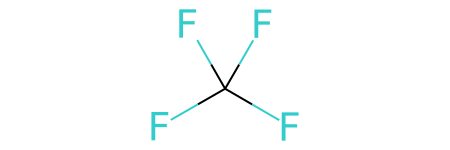

In [171]:
mol